# Comparison between local analysis and global analysis

In [1]:
import toml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from app.task import load_data, generate_gwas_dataset, compute_allele_frequencies_np, count_alleles, compute_maf  

# Loading parameters from TOML file
toml_file = "pyproject.toml"
config = toml.load(toml_file)
params = config["tool"]["flwr"]["app"]["config"]

num_partitions = 5

## Local analysis

In [10]:
# Concatenate all partitions into a single dataset
all_partitions = []
for i in range(num_partitions):  
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_snps = params["num_snps"], seed_value = params["seed_value"])

    if i==0 :
        print("Example of local dataset (head):")
        print(f"{data.head()}\n")

    df_counts = count_alleles(data)
    print(f"Partition {i}:\n")
    print(df_counts.head())


Example of local dataset (head):
  SNP_1 SNP_2 SNP_3 SNP_4 SNP_5 __index_level_0__
0    TT    CT    GG    AA    AA             Ind_1
1    CT    AT    AC    AG    CT             Ind_2
2    TT    GT    AA    GG    GT             Ind_3
3    GG    GG    CC    CT    TT             Ind_4
4    GC    GT    GC    AC    GT             Ind_5

Partition 0:

       A_count  C_count  G_count  T_count  Total_Alleles
SNP_1        8        9        9       14             40
SNP_2       18        5        8        9             40
SNP_3       16       11        5        8             40
SNP_4       13        8       15        4             40
SNP_5        9        8       10       13             40
Partition 1:

       A_count  C_count  G_count  T_count  Total_Alleles
SNP_1       10        8       13        9             40
SNP_2       13        9        9        9             40
SNP_3        7       13       10       10             40
SNP_4       14        7       10        9             40
SNP_5      

## Global analysis

In [3]:
# Concatenate all partitions into a single dataset
all_partitions = []
for i in range(num_partitions):  
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_snps = params["num_snps"], seed_value = params["seed_value"])
    #data["Partition"] = i
    all_partitions.append(data)  # Append DataFrame to list
merged_dataset = pd.concat(all_partitions)
df_counts = count_alleles(merged_dataset)

df_counts.head()

,A_count,C_count,G_count,T_count,Total_Alleles
SNP_1,44,49,51,56,200
SNP_2,64,41,53,42,200
SNP_3,47,60,33,60,200
SNP_4,46,52,54,48,200
SNP_5,51,35,53,61,200


In [4]:
# Example Usage
gwas_df = generate_gwas_dataset(num_individuals=params["num_individuals"], num_snps=params["num_snps"], seed_value=params["seed_value"])
print("GWAS Dataset:\n", gwas_df, "\n")

allele_counts_df = count_alleles(gwas_df)
print("Allele Counts:\n", allele_counts_df)


GWAS Dataset:
         SNP_1 SNP_2 SNP_3 SNP_4 SNP_5
Ind_1      TT    CT    GG    AA    AA
Ind_2      CT    AT    AC    AG    CT
Ind_3      TT    GT    AA    GG    GT
Ind_4      GG    GG    CC    CT    TT
Ind_5      GC    GT    GC    AC    GT
...       ...   ...   ...   ...   ...
Ind_96     GC    AT    GT    TT    AA
Ind_97     TT    AG    TT    GT    AT
Ind_98     TT    AG    TT    GG    AG
Ind_99     TT    CT    CC    GT    AA
Ind_100    AC    AA    TT    GT    AC

[100 rows x 5 columns] 

Allele Counts:
        A_count  C_count  G_count  T_count  Total_Alleles
SNP_1       44       49       51       56            200
SNP_2       64       41       53       42            200
SNP_3       47       60       33       60            200
SNP_4       46       52       54       48            200
SNP_5       51       35       53       61            200


In [5]:
# Example Usage
allele_frequencies_np = compute_allele_frequencies_np(allele_counts_df)
print("Allele Frequencies (NumPy Array):\n", allele_frequencies_np)


Allele Frequencies (NumPy Array):
 [[0.22  0.245 0.255 0.28 ]
 [0.32  0.205 0.265 0.21 ]
 [0.235 0.3   0.165 0.3  ]
 [0.23  0.26  0.27  0.24 ]
 [0.255 0.175 0.265 0.305]]


In [6]:
# Example Usage
maf_values = compute_maf(allele_frequencies_np)
print("Minor Allele Frequencies (NumPy Array):\n", maf_values)


Minor Allele Frequencies (NumPy Array):
 [0.22  0.205 0.165 0.23  0.175]


## Plots

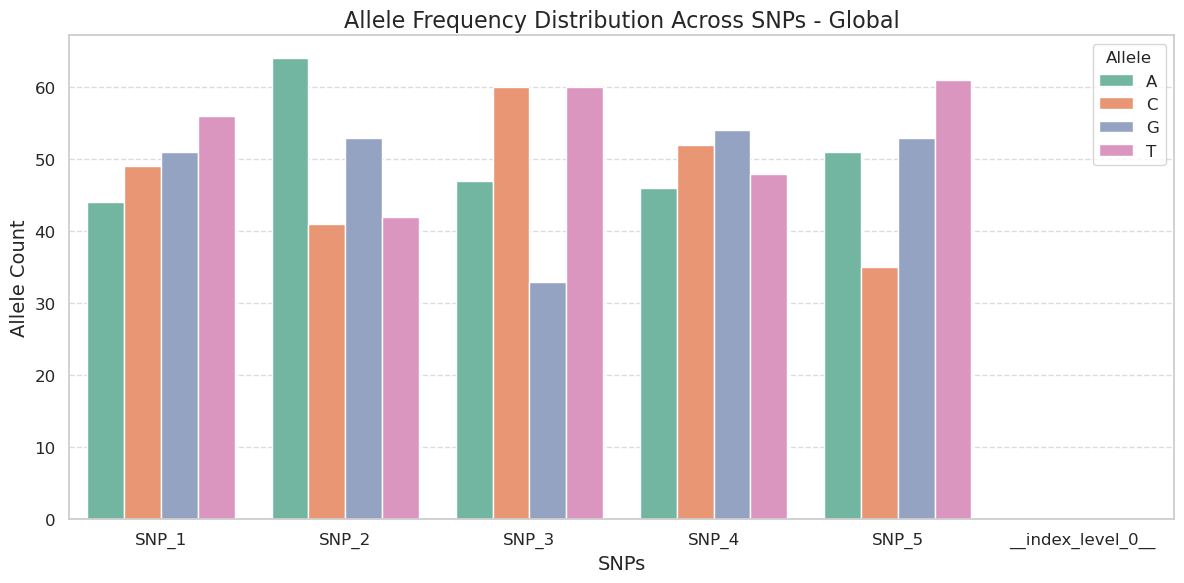

In [7]:
# Convert to long format for Seaborn
#df = pd.DataFrame(allele_counts_df)
df= df_counts
df['SNP'] = df.index
allele_data = df.melt(id_vars=["SNP"], value_vars=["A_count", "C_count", "G_count", "T_count"],
                      var_name="Allele", value_name="Count")

# Clean up allele names (remove "_count" from column names)
allele_data["Allele"] = allele_data["Allele"].str.replace("_count", "")

# Set Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 6))  # Set figure size
ax = sns.barplot(x="SNP", y="Count", hue="Allele", data=allele_data, palette="Set2")

# Customize plot
plt.xlabel("SNPs", fontsize=14)
plt.ylabel("Allele Count", fontsize=14)
plt.title("Allele Frequency Distribution Across SNPs - Global", fontsize=16)
plt.xticks(rotation=0, fontsize=12)  # Keep SNP labels readable
plt.yticks(fontsize=12)
plt.legend(title="Allele", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

IndexError: single positional indexer is out-of-bounds

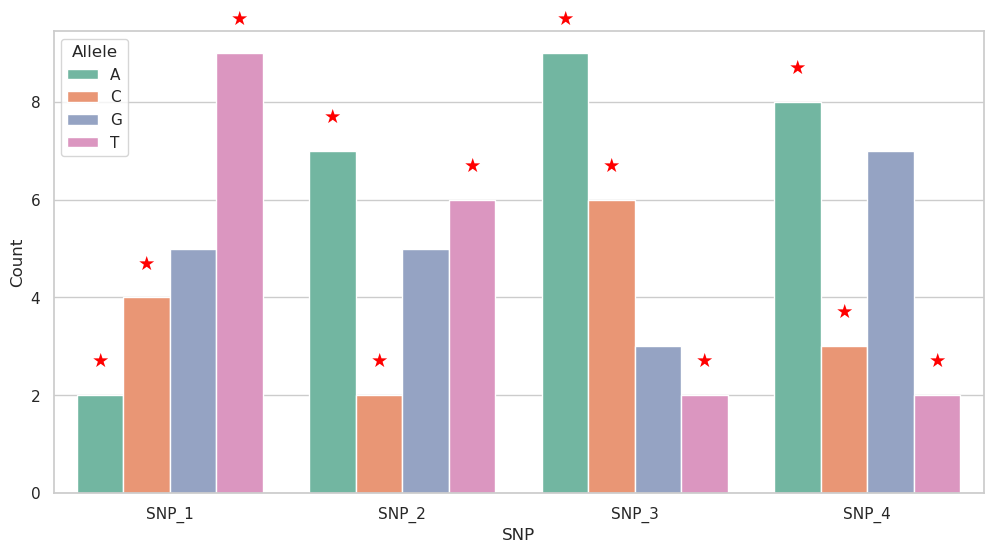

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample dataset
df_counts = pd.DataFrame({
    "SNP": ["SNP_1", "SNP_2", "SNP_3", "SNP_4"],
    "A_count": [2, 7, 9, 8],
    "C_count": [4, 2, 6, 3],
    "G_count": [5, 5, 3, 7],
    "T_count": [9, 6, 2, 2]
}).set_index("SNP")

# Identify the minor allele for each SNP
df_counts["Minor_Allele"] = df_counts.idxmin(axis=1)  # Column name of the allele with the lowest count

# Convert to long format for Seaborn
df = df_counts.copy()
df["SNP"] = df.index  # Add SNP column for melting
allele_data = df.melt(id_vars=["SNP"], value_vars=["A_count", "C_count", "G_count", "T_count"],
                      var_name="Allele", value_name="Count")

# Clean up allele names (remove "_count" from column names)
allele_data["Allele"] = allele_data["Allele"].str.replace("_count", "")

# Set Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="SNP", y="Count", hue="Allele", data=allele_data, palette="Set2")

# Add a star (*) above the minor allele bar
for i, bar in enumerate(ax.patches):
    snp_index = i // 4  # Each SNP has 4 bars (A, C, G, T)
    allele = allele_data.iloc[i]["Allele"]
    
    # Check if this is the minor allele
    if allele == df_counts.iloc[snp_index]["Minor_Allele"].replace("_count", ""):
        bar_x = bar.get_x() + bar.get_width() / 2  # Get center of the bar
        bar_y = bar.get_height()  # Get bar height
        ax.text(bar_x, bar_y + 0.5, "★", ha="center", va="bottom", fontsize=14, color="red", fontweight="bold")

# Customize plot
plt.xlabel("SNPs", fontsize=14)
plt.ylabel("Allele Count", fontsize=14)
plt.title("Allele Frequency Distribution Across SNPs (Minor Allele Highlighted)", fontsize=16)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Allele", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()
